In [ ]:
import numpy as np
import pandas as pd
from classes import *
import random

Growth Network Classes loaded


In [4]:
class Node_Gene:

    def __init__(self, node_id, layer, activation_function='ReLU'):
        """
    Node class represents the genetic encoding for a single neuron in a network.

    :param node_id: Unique identifier for the node
    :param layer: Type of node (e.g., 'input', 'output' or a number for hidden layers)
    :param activation_function: Activation function for the node (default is 'ReLU')
    """

        self.id  = node_id  # Unique identifier for the node
        self.type = layer # Type of node (e.g., 'input', 'output' or a number for hidden layers)
        self.act_func = activation_function #define code later

class Edge_Gene:
    def __init__(self, edge_id, IN, OUT, weight, enabled=True):
        """
        Edge class is the genetic encoding for a single connnection in a network.
        Each edge_gene defines a connection between two neurons with a weight.

        :param edge_id: Unique identifier for the gene
        :param IN: Input neuron (source node)
        :param OUT: Output neuron (target node)
        :param weight: Weight of the connection (can be positive or negative)
        :param enabled: Boolean indicating if the gene is enabled or disabled
        """
        self.id = edge_id  # Unique identifier for the gene
        self.IN = IN  # Input neuron
        self.OUT = OUT # Output neuron
        self.weight = weight  #weight
        self.enabled = enabled # Boolean indicating if the gene is enabled or disabled

    def show(self, display=False):
        """
        Print gene information. currently uses pandas
        """

        # Create a DataFrame to display gene information
        df = pd.DataFrame({
            'Gene ID': [self.id],
            'Input Neuron': [self.IN],
            'Output Neuron': [self.OUT],
            'Weight': [self.weight],
            'Enabled': [self.enabled]
        })
        # if display:
        #     display(df.T)
        return(df)

class Chromosome:
    def __init__(self, chromosome_id, edges=None, nodes=None, inputs=None, outputs=None, hidden=None):
        """
        Chromosome class represents a collection of genes
        Each chromosome can be thought of as a set of instructions for growing the neural network.

        :param chromosome_id: Unique identifier for the chromosome
        :param edges: List of edge genes in this chromosome
        :param nodes: List of node genes in this chromosome
        """

        if edges is None and nodes is None: #random intialization of the chromosome

            connectivity_ratio = 0.75 #ratio of connections to nodes

            nodes = []
            edges = []
            #Create iterables
            input_ids = range(inputs)
            hidden_ids = range(inputs, inputs + hidden)
            output_ids = range(inputs + hidden, inputs + hidden + outputs)

            #Create nodes per the number of inputs, outputs and hidden nodes
            for _ in range(inputs): nodes.append(Node_Gene(len(nodes), 'input'))
            for _ in range(hidden): nodes.append(Node_Gene(len(nodes), 1))
            for _ in range(outputs): nodes.append(Node_Gene(len(nodes), 'output'))

            # Create edges between input and hidden nodes
            for i in input_ids:
                connectable_hidden = random.sample(hidden_ids, random.randint(int(hidden*connectivity_ratio), hidden)) #choose a lower bound
                for h in connectable_hidden:
                    weight = np.random.uniform(-1, 1)
                    edges.append(Edge_Gene(len(edges), i, h, weight))

            # Create edges between hidden and output nodes
                for h in hidden_ids:
                    connectable_output = random.sample(output_ids, random.randint(int(outputs*connectivity_ratio), outputs)) #choose a lower bound
                    for o in connectable_output:
                        weight = np.random.uniform(-1, 1)
                        edges.append(Edge_Gene(len(edges), h, o, weight))

        self.id = chromosome_id  # Unique identifier for the chromosome
        self.nodes = nodes  # List to hold node_genes in this chromosome
        self.edges = edges  # List to hold edge_genes in this chromosome

    def add(self, edges):
        """
        Add a edge to the chromosome.

        :param edges: Gene object to be added
        """
        self.edges.extend(edges.tolist())  # extended the gene to the list of genes

    def show(self):
        output=pd.DataFrame()
        for edge in self.edges:
            df = edge.show()
            output = pd.concat([output, df], ignore_index=True)
        print(output) #jupyter will automatically display

    def create_adjacency_matrix(self):
        """
        Builds and returns the adjacency matrix from the gene connections.
        Nodes are auto-discovered from genes.
        """
        # Find unique neuron IDs
        neuron_ids = sorted(set(e.IN for e in self.edges) | set(e.OUT for e in self.edges))
        neuron_to_index = {nid: idx for idx, nid in enumerate(neuron_ids)}

        # Initialize matrix
        n = len(neuron_ids)
        matrix = np.zeros((n, n))

        # Fill matrix using genes
        for edge in self.edges:
            if edge.enabled:
                i = neuron_to_index[edge.IN]
                j = neuron_to_index[edge.OUT]
                matrix[i, j] = edge.weight  # directed from IN to OUT


        return matrix, neuron_to_index

class Network: #represents an induvidual in the population
    def __init__(self, network_id, chromosomes=None, inputs=None, outputs=None):
        """
        Network class represents a neural network built from a collection of chromosome.
        It can be used for forward propagation and other operations.

        :param network_id: Unique identifier for the network
        :param inputs: num input nodes
        :param outputs: num output nodes
        :param chromosomes: List of chromosome objects
        """
        #random intialization of the network
        if chromosomes is None:
            num_hidden_nodes = random.randint(1, 5)
            #run func to generate random chromosomes bases on num inputs and num outputs
            self.genotype = []
            self.genotype[0] = Chromosome(0, inputs=inputs, outputs=outputs, hidden=num_hidden_nodes) #embryonic enc choromosome (C0)

        self.id = network_id
        self.genotype = chromosomes  # Chromosome object

    def grow(self, iterations=1):
        """
        Grows the network by adding genes to C0 based on regulatory chromosomes C1-Cn.
        This iterative process simulates developmental growth of the neural network.
        
        :param iterations: Number of growth iterations to perform
        """
        if len(self.genotype) <= 1:  # If we only have C0 or no chromosomes
            print("No regulatory chromosomes (C1-Cn) available for growth")
            return
        
        C0 = self.genotype[0]  # The main neural network chromosome
        
        for iteration in range(iterations):
            print(f"Growth iteration {iteration + 1}/{iterations}")
            
            # Get the current state of C0
            current_nodes = len(C0.nodes)
            current_edges = len(C0.edges)
            
            # Process each regulatory chromosome (C1-Cn)
            for chrom_idx in range(1, len(self.genotype)):
                regulatory_chrom = self.genotype[chrom_idx]
                
                # Create a graph representation of the regulatory chromosome
                reg_matrix, reg_neuron_map = regulatory_chrom.create_adjacency_matrix()
                
                # Determine which genes to add based on the regulatory network
                new_edges = self._evaluate_regulatory_network(
                    regulatory_chrom, 
                    reg_matrix, 
                    reg_neuron_map, 
                    iteration
                )
                
                # Add the new edges to C0
                if new_edges:
                    C0.add(new_edges)
                    print(f"Added {len(new_edges)} new connections from regulatory chromosome {chrom_idx}")
        
        print(f"Growth complete. C0 now has {len(C0.nodes)} nodes and {len(C0.edges)} connections.")

    def _evaluate_regulatory_network(self, reg_chrom, reg_matrix, reg_neuron_map, current_age):
        """
        Evaluates a regulatory chromosome to determine which genes to add to C0.
        
        :param reg_chrom: The regulatory chromosome being evaluated
        :param reg_matrix: Adjacency matrix of the regulatory network
        :param reg_neuron_map: Mapping of neuron IDs to matrix indices
        :param current_age: Current growth iteration/age
        :return: List of new Edge_Gene objects to add to C0
        """
        # This is a simplified implementation - you would expand this based on your specific needs
        
        # Get the basic properties of C0
        C0 = self.genotype[0]
        C0_node_ids = [node.id for node in C0.nodes]
        
        new_edges = []
        
        # Simple rule: For each active edge in the regulatory network, potentially add a new edge to C0
        # The activation of regulatory edges could depend on the current age/iteration
        activation_threshold = 0.5 - (0.1 * current_age)  # Threshold decreases with age
        
        # Get dimensions of the regulatory matrix
        reg_size = reg_matrix.shape[0]
        
        # Analyze the regulatory network to determine new connections
        for i in range(reg_size):
            for j in range(reg_size):
                if reg_matrix[i, j] > activation_threshold:
                    # This regulatory connection is active - use it to guide growth
                    
                    # Find potential source and target nodes in C0
                    # (This is a simplified approach - you could use more complex mapping)
                    potential_sources = [n for n in C0_node_ids if n % (reg_size + 1) == i]
                    potential_targets = [n for n in C0_node_ids if n % (reg_size + 1) == j]
                    
                    # If we have both source and target candidates, create a new connection
                    if potential_sources and potential_targets:
                        source = random.choice(potential_sources)
                        target = random.choice(potential_targets)
                        
                        # Check if this connection already exists
                        if not any(e.IN == source and e.OUT == target for e in C0.edges):
                            # Create a new edge with weight influenced by the regulatory network
                            weight = np.random.uniform(-1, 1) * reg_matrix[i, j]
                            new_edge = Edge_Gene(len(C0.edges), source, target, weight)
                            new_edges.append(new_edge)
        
        # Convert to numpy array if needed for the add method
        if new_edges:
            return np.array(new_edges)
        return []



In [5]:
# Assuming Node_Gene, Edge_Gene, Chromosome, and Network classes are already defined

# Step 1: Create a basic network with 3 inputs, 2 outputs
network_id = 1
num_inputs = 3
num_outputs = 2
num_hidden = 4

# Step 2: Create C0 (the main neural network chromosome)
C0 = Chromosome(chromosome_id=0, inputs=num_inputs, outputs=num_outputs, hidden=num_hidden)

# Step 3: Create C1 (a regulatory chromosome) - simple regulatory network with 3 nodes
reg_nodes = []
reg_edges = []

# Create nodes for the regulatory network
for i in range(3):
    reg_nodes.append(Node_Gene(i, 1))  # All nodes in layer 1 for simplicity

# Create some edges in the regulatory network
reg_edges.append(Edge_Gene(0, 0, 1, 0.7))  # Node 0 connects to Node 1 with weight 0.7
reg_edges.append(Edge_Gene(1, 1, 2, 0.8))  # Node 1 connects to Node 2 with weight 0.8
reg_edges.append(Edge_Gene(2, 0, 2, 0.5))  # Node 0 connects to Node 2 with weight 0.5

C1 = Chromosome(chromosome_id=1, edges=reg_edges, nodes=reg_nodes)

# Step 4: Create the network with these chromosomes
my_network = Network(network_id=1, chromosomes=[C0, C1], inputs=num_inputs, outputs=num_outputs)

# Step 5: Grow the network for a few iterations
my_network.grow(iterations=3)

# Step 6: Examine the resulting network
print("Final network structure:")
my_network.genotype[0].show()  # Display the structure of C0 after growth

Growth iteration 1/3
Added 1 new connections from regulatory chromosome 1
Growth iteration 2/3


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
C0 = Chromosome(0, inputs=3, outputs=2, hidden=4)
M, _ = C0.create_adjacency_matrix()






NameError: name 'random' is not defined

In [6]:
#define some nodes and edge
edge1 = Edge_Gene(1,0,1,0.5)
edge2 = Edge_Gene(2,1,2,0.8)
edge3 = Edge_Gene(3,2,3,0.2)
edge4 = Edge_Gene(4,3,4,0.1)
edge5 = Edge_Gene(5,4,5,0.6)
edge6 = Edge_Gene(6,5,6,0.4)
edge7 = Edge_Gene(7,6,7,0.9)



node0 = Node_Gene(0, 'input')
node1 = Node_Gene(1, 'input')
node2 = Node_Gene(2, 'output')
node3 = Node_Gene(3, 'output')
node4 = Node_Gene(4, 1)
node5 = Node_Gene(5, 1)
node6 = Node_Gene(6, 2)
node7 = Node_Gene(7, 2)


In [7]:
C1 = Chromosome(1, edges=[edge1, edge2, edge3, edge4, edge5, edge6, edge7], nodes=[node0, node1, node2, node3, node4, node5, node6, node7])
C1.show()

   Gene ID  Input Neuron  Output Neuron  Weight  Enabled
0        1             0              1     0.5     True
1        2             1              2     0.8     True
2        3             2              3     0.2     True
3        4             3              4     0.1     True
4        5             4              5     0.6     True
5        6             5              6     0.4     True
6        7             6              7     0.9     True


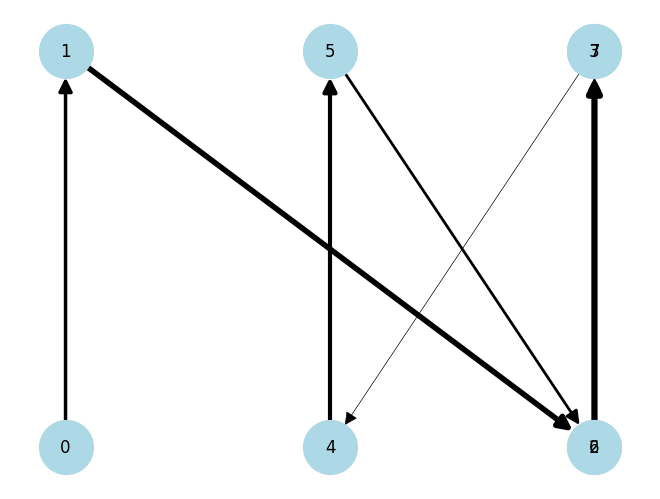

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_layer_positions(nodes):

    layer_nodes = defaultdict(list)

    # Group nodes by their layer
    for node in nodes:
        if node.type == 'input':
            layer_nodes[0].append(node)
        elif node.type == 'output':
            layer_nodes['output'].append(node)
        else:
            layer_nodes[node.type].append(node)

    # Determine number of hidden layers and output layer x-position
    hidden_layers = sorted([k for k in layer_nodes.keys() if isinstance(k, int)])
    max_hidden_layer = max(hidden_layers) if hidden_layers else 0
    output_layer_x = max_hidden_layer + 1

    # Assign x-values
    layer_x = {}
    layer_x[0] = 0  # Input layer
    for i, layer in enumerate(hidden_layers):
        layer_x[layer] = i + 1
    layer_x['output'] = output_layer_x

    # Assign y-positions
    positions = {}
    for layer, nodes_in_layer in layer_nodes.items():
        x = layer_x[layer]
        num_nodes = len(nodes_in_layer)
        y_spacing = 1
        y_start = -((num_nodes - 1) / 2) * y_spacing
        for i, node in enumerate(nodes_in_layer):
            y = y_start + i * y_spacing
            positions[node.id] = (x, y)

    return positions

def plot_chromosome(chromosome):
    # Create adjacency matrix and neuron-to-index mapping
    adj_matrix, neuron_to_index = chromosome.create_adjacency_matrix()

    # Create a directed graph from the adjacency matrix
    gA = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())

    # Generate positions for nodes
    layer_positions = generate_layer_positions(chromosome.nodes)

    # Extract edge weights
    edges = gA.edges()
    weights = [gA[u][v]['weight'] for u, v in edges]
    scaled_weights = [5 * abs(w) for w in weights]  # Scale edge widths

    # Draw the graph
    nx.draw(gA, pos=layer_positions, with_labels=True,
            node_color='lightblue', node_size=1500,
            arrowsize=20, width=scaled_weights)
    plt.show()

plot_chromosome(C1)